# **Notebook 1: Reti Neurali from scratch**

Gabriele Fumagalli (845108), Veronica Morelli (839257), Davide Valoti (846737).


Per sviluppare questo progetto utilizziamo il dataset ***FoodX-251***. Il dataset FoodX-251 contiene immagini relative al cibo e classificate in 251 categorie.

Il dataset è suddiviso in:
-         *training set*: 118475 immagini
-         *validation set*: 11994 immagini
-         *validation set degradato*: 11994 immagini

Le immagini si trovano nei file *train.tar*, *val.tar*, *val_degraded.tar*. <br>
Le informazione alla categoria di appartenenza di ogni immagine si trovano nei file *train_info.csv*, *val_info.csv* e *test_info.csv*.

Utilizziamo il dataset per risolvere un **problema di classificazione**. Vogliamo trovare un modello di deep learning performante per classificare correttamente 251 tipi di cibo.

Utilizziamo principalmente due approcci:

* **Rete neurale from scratch**
* **Transfer learning, Fine Tuning e feature extraction**

Nel primo caso progettiamo una nuova architettura di rete neurale convoluzionale da zero. 

Nel secondo caso utilizziamo completamente o parzialmente una Rete Neurale pre-addestrata aggiungendo una Rete Neurale Feed-Forward nella parte finale.

Nella prima parte del notebook proponiamo diverse **Reti neurali from scratch**. Partiamo da una rete neurale di base con solo 2 strati convoluzionali e cerchiamo di migliorare le sue prestazioni facendo diverse prove.

Abbiamo creato un account **colab pro** per avere una GPU più veloce e più spazio in memoria RAM.

Abbiamo creato tre account su **Azure Machine Learning studio** per poter avere una GPU più veloce.

Nonostante ciò è stato necessario effettuare dei campionamenti. 


## 1) **Impostazione dell'ambiente**

Questa sezione serve a configurare l'ambiente e importare le librerie utili:

In [ ]:
# Importazione librerie utili

import os
import glob
from time import time
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import zipfile

import random 
from random import seed
from random import random

import matplotlib.pyplot as plt
import IPython.display as ipd # Solo nel notebook

import seaborn as sns

# Image Management 
from skimage import io
from skimage import transform
from PIL import Image

# Classificazione
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image as kimage
from keras.applications import ResNet50 

# File management
from google.colab import drive
import tarfile
import shutil
from shutil import copyfile

In [ ]:
# Impostazioni per una visualizzazione più bella in Google Colab
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
# Mount GDrive
drive.mount('/content/gdrive/', force_remount = True) 

Mounted at /content/gdrive/


## 2) **Caricamento e campionamento delle immagini**

Nel nostro caso, la fase di preparazione dei dati per le analisi successive consiste in due fasi: **caricamento dei dati sull'unità** e **campionamento**. A causa delle limitate risorse computazionali e di memoria a nostra disposizione è stato necessario eseguire un forte campionamento che ha notevolmente ridotto la dimensione del dataset di training e di validation. <br>
In generale, la fase di caricamento e campionamento dei dati si è svolta nel seguente modo:

1. Caricamento file *train.tar* e *val.tar* su drive

2. Selezione di *n* immagini per classe per creare il dataset di training e il dataset di validation. Per questa operazione si sfruttano le informazioni contenenti nei file *train_info.csv* e *val_info.csv*.

3. Selezione delle immagini nei file *train.tar* e *val.tar*. Creazione delle cartelle *Train* e *Validation* contenenti le immagini selezionate. 

Si creano diversi dataset:

* `Train`: 100 immagini per classe - `Validation`: 20 immagini per classe
* `Train Reduced`: 30 immagini per classe - `Validation Reduced`: 9 immagini per classe
* `Train Reduced2`: 20 immagini per classe - `Validation Reduced2`: 5 immagini per classe

Questa procedura è necessaria a causa delle limitazioni di memoria RAM che l'account colab pro ha. 

### `Train`

Il file *train_info.csv* è organizzato su due colonne: la prima contiene i nomi delle immagini, la seconda contiene la classe di appartenenza. <br>
Selezioniamo 100 immagini per classe. 

In [ ]:
train_info = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Annot/train_info.csv', header=None)

In [ ]:
type(train_info)

pandas.core.frame.DataFrame

In [ ]:
train_info.shape
# 118475 immagini di train

(118475, 3)

In [ ]:
train_info.columns

Int64Index([0, 1, 2], dtype='int64')

In [ ]:
train_info.head(10)

,0,1,2
0,NaN,train_101733.jpg,211
1,0.0,train_101734.jpg,211
2,1.0,train_101735.jpg,211
3,2.0,train_101736.jpg,211
4,3.0,train_101737.jpg,211
5,4.0,train_101738.jpg,211
6,5.0,train_101739.jpg,211
7,6.0,train_101740.jpg,211
8,7.0,train_101741.jpg,211
9,8.0,train_101742.jpg,211


In [ ]:
# Selezione colonne di interesse
train_info = train_info[[1,2]]

In [ ]:
train_info.head(10)

,1,2
0,train_101733.jpg,211
1,train_101734.jpg,211
2,train_101735.jpg,211
3,train_101736.jpg,211
4,train_101737.jpg,211
5,train_101738.jpg,211
6,train_101739.jpg,211
7,train_101740.jpg,211
8,train_101741.jpg,211
9,train_101742.jpg,211


In [ ]:
# Rinominazione colonne con: 
# - Name: nome immagine
# - Class: categoria di appartenenza
train_info = train_info.rename(columns={1: 'Name', 2: 'Class'})

In [ ]:
train_info.columns

Index(['Name', 'Class'], dtype='object')

**Valori unici**

In [ ]:
classes = train_info['Class'].unique()

In [ ]:
type(classes)

numpy.ndarray

In [ ]:
classes = np.sort(classes)

In [ ]:
classes
# 251 classi dalla 0 alla 250

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
train_info['Class'].value_counts(ascending=True)
# La classe 162 contiene 34 immagini --> le selezioniamo tutte 
# Per ognuna delle altre classi selezioniamo 100 immagin 

162     34
213    277
164    289
83     290
103    300
      ... 
117    617
0      633
155    635
147    636
218    656
Name: Class, Length: 251, dtype: int64

In [ ]:
# Selezioniamo le immagini che appartengono alla classe 162
class162 = train_info.loc[train_info['Class'] == 162]

In [ ]:
class162.shape
# 34 immagini

(34, 2)

In [ ]:
# eliminiamo da train_info le immagini appartenenti a classe 162
train_info2 = train_info[train_info.Class != 162]

In [ ]:
train_info.shape

(118475, 2)

In [ ]:
train_info2.shape
# 118475 - 34 = 118441

(118441, 2)

In [ ]:
# Selezioniamo 100 immagini per classe
train_info_100 = train_info2.groupby('Class', group_keys=False).apply(lambda x: x.sample(100))

In [ ]:
train_info_100

,Name,Class
77200,train_059832.jpg,0
77177,train_059809.jpg,0
76809,train_059440.jpg,0
77216,train_059848.jpg,0
77191,train_059823.jpg,0
...,...,...
17748,train_119773.jpg,250
17849,train_119874.jpg,250
17827,train_119852.jpg,250
17733,train_119758.jpg,250


In [ ]:
train_info_100['Class'].value_counts(ascending=True)

0      100
158    100
159    100
160    100
161    100
      ... 
89     100
90     100
91     100
78     100
250    100
Name: Class, Length: 250, dtype: int64

In [ ]:
# Uniamo a train_info_100 le 34 immagini appartenenti alla classe 162
train_info_100fin = pd.concat([train_info_100, class162], axis=0)

In [ ]:
train_info_100fin

,Name,Class
77200,train_059832.jpg,0
77177,train_059809.jpg,0
76809,train_059440.jpg,0
77216,train_059848.jpg,0
77191,train_059823.jpg,0
...,...,...
57366,train_039689.jpg,162
57367,train_039690.jpg,162
57368,train_039691.jpg,162
57369,train_039692.jpg,162


In [ ]:
lista_imtrain = list(train_info_100fin['Name'])

In [ ]:
type(lista_imtrain)

list

In [ ]:
type(train_info_100fin)

pandas.core.frame.DataFrame

In [ ]:
# Salviamo il file 
train_info_100fin.to_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/train_info_100fin.csv')

In [ ]:
# Import file train.tar
train_tar = tarfile.open("/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/train.tar")
train_tar.extractall()

Le immagini si trovano in una cartella chiamata *train_set*. <br>
Esempio di path: ./train_set/train_114082.jpg


In [ ]:
type(train_tar)

tarfile.TarFile

In [ ]:
namelist_train = train_tar.getnames()
namelist_train

In [ ]:
# Destination directory
# Nella cartella train verranno copiate le immagini selezionate precedentemente dal campionamento stratificato
dst = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Train/'

In [ ]:
i = 0
for im_name in os.listdir('/content/train_set/'): 

  dir_im = '/content/train_set/' + im_name
  dst_im = dst + im_name

  if im_name in lista_imtrain:
    shutil.copyfile(dir_im, dst_im)
    i +=1

In [ ]:
print(i)
# 25034 immagini di train

25034


In [ ]:
train_tar.close()

### `Validation`

Il file *val_info.csv* è organizzato su due colonne: la prima contiene i nomi delle immagini, la seconda contiene la classe di appartenenza. <br>
Selezioniamo 20 immagini per classe. 

In [ ]:
val_info = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Annot/val_info.csv', header=None)

In [ ]:
type(val_info)

pandas.core.frame.DataFrame

In [ ]:
val_info.shape
# 11994 immagini di validation

(11994, 3)

In [ ]:
val_info.columns

Int64Index([0, 1, 2], dtype='int64')

In [ ]:
val_info.head(10)

,0,1,2
0,NaN,val_010323.jpg,247
1,0.0,val_010324.jpg,234
2,1.0,val_010325.jpg,222
3,2.0,val_010326.jpg,240
4,3.0,val_010327.jpg,218
5,4.0,val_010328.jpg,221
6,5.0,val_010329.jpg,243
7,6.0,val_010330.jpg,243
8,7.0,val_010331.jpg,222
9,8.0,val_010332.jpg,237


In [ ]:
val_info = val_info[[1,2]]

In [ ]:
val_info.head(10)

,1,2
0,val_010323.jpg,247
1,val_010324.jpg,234
2,val_010325.jpg,222
3,val_010326.jpg,240
4,val_010327.jpg,218
5,val_010328.jpg,221
6,val_010329.jpg,243
7,val_010330.jpg,243
8,val_010331.jpg,222
9,val_010332.jpg,237


In [ ]:
val_info = val_info.rename(columns={1: 'Name', 2: 'Class'})

In [ ]:
val_info.columns

Index(['Name', 'Class'], dtype='object')

In [ ]:
classes2 = val_info['Class'].unique()

In [ ]:
classes2 = np.sort(classes2)

In [ ]:
classes2

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
val_info['Class'].value_counts(ascending=True).head(20)
# Selezioniamo tutti le immagini di classe 116, 189, 238 e 239 --> totale 39 immagini
# Per le altre classi selezioniamo 20 immagini

116     2
189     9
238    11
239    17
99     21
149    22
213    23
65     24
83     26
159    26
117    27
218    30
18     31
50     32
235    33
163    33
191    34
240    34
215    34
129    35
Name: Class, dtype: int64

In [ ]:
# Selezioniamo le immagini che appartengono alla classe 116, 189, 238 e 239
val_info_reduced = val_info.loc[(val_info['Class'] == 116) | (val_info['Class'] == 189) | (val_info['Class'] == 238) | (val_info['Class'] == 239)]

In [ ]:
val_info_reduced.head(5)

,Name,Class
205,val_010533.jpg,239
229,val_010559.jpg,239
251,val_010581.jpg,238
352,val_010685.jpg,238
442,val_010775.jpg,238


In [ ]:
val_info_reduced.shape
# 39 immagini

(39, 2)

In [ ]:
# eliminiamo da val_info le immagini appartenenti a classe 116, 189, 238 e 239
val_info2 = val_info[(val_info.Class != 116) & (val_info.Class != 189) & (val_info.Class != 238) & (val_info.Class != 239)]

In [ ]:
val_info.shape

(11994, 2)

In [ ]:
val_info2.shape
# 11994 - 39 = 11955

(11955, 2)

In [ ]:
val_info2['Class'].value_counts(ascending=True).head(20)

99     21
149    22
213    23
65     24
83     26
159    26
117    27
218    30
18     31
50     32
163    33
235    33
215    34
240    34
191    34
143    35
59     35
40     35
230    35
109    35
Name: Class, dtype: int64

In [ ]:
# Selezione 20 immaini per classe
val_info_20 = val_info2.groupby('Class', group_keys=False).apply(lambda x: x.sample(20))

In [ ]:
val_info_20
# (251-4)*20=4940

,Name,Class
7730,val_005999.jpg,0
5364,val_003605.jpg,0
10476,val_008780.jpg,0
1890,val_000078.jpg,0
7901,val_006173.jpg,0
...,...,...
1516,val_011867.jpg,250
788,val_011128.jpg,250
787,val_011127.jpg,250
607,val_010943.jpg,250


In [ ]:
val_info_20['Class'].value_counts(ascending=True)

0      20
157    20
158    20
159    20
160    20
       ..
87     20
88     20
89     20
91     20
250    20
Name: Class, Length: 247, dtype: int64

In [ ]:
val_info_20fin = pd.concat([val_info_20, val_info_reduced], axis=0)

In [ ]:
val_info_20fin

,Name,Class
7730,val_005999.jpg,0
5364,val_003605.jpg,0
10476,val_008780.jpg,0
1890,val_000078.jpg,0
7901,val_006173.jpg,0
...,...,...
8385,val_006665.jpg,189
9417,val_007712.jpg,189
10024,val_008322.jpg,189
10366,val_008666.jpg,189


In [ ]:
lista_imval = list(val_info_20fin['Name'])

In [ ]:
val_info_20fin.to_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/val_info_20fin.csv')

In [ ]:
val_tar = tarfile.open("/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/val.tar")
val_tar.extractall()

In [ ]:
type(val_tar)

In [ ]:
namelist_val = val_tar.getnames()
namelist_val

In [ ]:
# Destination directory
# Nella cartella train verranno copiate le immagini selezionate precedentemente dal campionamento stratificato
dstval = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Validation/'

In [ ]:
lista_imval

In [ ]:
i=0
for im_name in os.listdir('/content/val_set/'): 

  dir_im = '/content/val_set/' + im_name
  dst_im = dstval + im_name

  if im_name in lista_imval:
    if (os.path.exists(dstval)): # se la cartella esiste --> aggiungi il file
      shutil.copyfile(dir_im, dst_im)  
      i+=1

In [ ]:
print(i)

In [ ]:
val_tar.close()

Allo stesso modo si creano `Training Reduced`, `Validation Reduced`, `Training Reduced2` e `Validation Reduced2`.

## 3) **Data Loader**

Prima di procedere alla fase di analisi vera e propria, è necessario dividere l'intero set di dati in due set: **training set** e **validation set**. In questo caso si utilizzano i dataset contenenti nelle cartelle `Train Reduced2` e `Validation Reduced2`. Il training set contiene 5020 immagini, mentre il valdiation set contiene 1252 immagini. A causa dello spazio limitato nella RAM non è possibile utilizzare una quantità di dati maggiore. 

Il fase di caricamento dati si divide in 3 step:

1. Import dei file contenenti il nome dell'immagine e la rispettiva classe, chiamata anche label. 

2. Definizione del data loader e stack delle immagini in una matrice Numpy da dare in input al classificatore.

3. Conversione un vettore di classi (labels) in una matrice di classi binarie.

Il data loader carica un'immagine alla volta, ridimensiona l'immagine ad una dimensione di (256,256) e la standardizza (*rescale=1.0/255.0*). Il data loader è definito sia per il training set che per il validation set. Non è stata aggiunta data augmentation sul training set. 

### 3.1) **Import file con labels**

In [ ]:
#colnames=['img_name', 'label'] 
train_labels = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/train_info_20.csv')
val_labels = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/val_info_5fin.csv')

In [ ]:
train_labels

,Unnamed: 0,Name,Class
0,77095,train_059727.jpg,0
1,77249,train_059881.jpg,0
2,77156,train_059788.jpg,0
3,77034,train_059666.jpg,0
4,76874,train_059506.jpg,0
...,...,...,...
5015,17835,train_119860.jpg,250
5016,17873,train_119898.jpg,250
5017,17866,train_119891.jpg,250
5018,18146,train_120174.jpg,250


In [ ]:
train_labels = train_labels[['Name', 'Class']]
val_labels = val_labels[['Name', 'Class']]

In [ ]:
train_labels

,Name,Class
0,train_059727.jpg,0
1,train_059881.jpg,0
2,train_059788.jpg,0
3,train_059666.jpg,0
4,train_059506.jpg,0
...,...,...
5015,train_119860.jpg,250
5016,train_119898.jpg,250
5017,train_119891.jpg,250
5018,train_120174.jpg,250


In [ ]:
val_labels

,Name,Class
0,val_005669.jpg,0
1,val_009277.jpg,0
2,val_003592.jpg,0
3,val_003603.jpg,0
4,val_006295.jpg,0
...,...,...
1247,val_010963.jpg,250
1248,val_010595.jpg,250
1249,val_010637.jpg,250
1250,val_001933.jpg,116


### 3.2 **Data Loader `Train Reduced2` e `Validation Reduced2`**

In [ ]:
train_path = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Train Reduced2/'
val_path = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Validation Reduced2/'

In [ ]:
i = 0
for im in os.listdir(train_path):
  i+=1

In [ ]:
i
# 5020 immagini di train

5020

In [ ]:
i = 0
for im in os.listdir(val_path):
  i+=1

In [ ]:
i
# 1252 immagini di validation

1252

**Data Loader Train set**

In [ ]:
train_images = []
for image_file in os.listdir(train_path):
    image = Image.open(train_path+image_file)
    newsize = (256, 256)
    image = image.resize(newsize)
    image = np.array(image)
    image = image*1.0/255 # normalizzazione
    train_images.append(image)

# Converte la lista di immagini in una matrice NumPy
train_images = np.stack(train_images)

print(train_images.shape) # Stampa le dimensioni della matrice (numero di immagini, altezza, larghezza, canali)

(5020, 256, 256, 3)


**Data Loader Validation set**

In [ ]:
valid_images = []
for image_file in os.listdir(val_path):
    image = Image.open(val_path+image_file)
    newsize = (256, 256)
    image = image.resize(newsize)
    image = np.array(image)
    image = image*1.0/255 # normalizzazione
    valid_images.append(image)

# Converte la lista di immagini in una matrice NumPy
valid_images = np.stack(valid_images)

print(valid_images.shape)  # Stampa le dimensioni della matrice (numero di immagini, altezza, larghezza, canali)

(1252, 256, 256, 3)


**Labels Training set**

In [ ]:
df_labels = pd.DataFrame(os.listdir(train_path),
                         columns=['Name'])
# df_labels.head

join_labels = df_labels.merge(train_labels, on='Name', how='left')
train_labels=join_labels['Class'].tolist()

one_hot_encoded_train_labels = tf.keras.utils.to_categorical(train_labels)
len(one_hot_encoded_train_labels)

**Labels Validation set**

In [ ]:
df_labels = pd.DataFrame(os.listdir(val_path),
                        columns=['Name'])
# df_labels.head

join_labels=df_labels.merge(val_labels, on='Name', how='left')
valid_labels=join_labels['Class'].tolist()

one_hot_encoded_val_labels = tf.keras.utils.to_categorical(valid_labels)
len(one_hot_encoded_val_labels)

1252

## 4) **Classificazione from Scratch**

Come detto precedentemente, proponiamo diverse **Reti neurali from scratch**. Partiamo da una rete neurale di base con solo 2 strati convoluzionali e cerchiamo di migliorare le sue prestazioni facendo diverse prove: cambiando i parametri, aggiungendo complessità e cercando di stabilizzare la rete.

Tutti i modelli vengono salvati nella cartella *Models* per permettere in futuro la classificazione su immagini di test.

**Step principali**

Gli step principali per definire una rete neurale sono i seguenti:

1.	Definizione dell'architettura
2.	Compilazione: definizione dei macroelementi della rete (ottimizzatore, tasso di apprendimento nell'ottimizzatore (learning rate), funzione di perdita, metriche aggiuntive, parametri aggiuntivi, ecc.) 
4.	Addestramento (epoche, dimensione del batch, ecc.).
5.	Riassunto (summary) e visualizzazione dei risultati

In generale, le impostazioni sono le seguenti:

**Compilazione** 
* ottimizzatore: RMSprop
* funzione di perdita: categorical crossentropy
* metrica: categorical accuracy

**Fitting**
* batch size: 100
* epoche: 50










In [ ]:
# Numero di classi da predire
num_classes = 251

### 1. **Model v1**

**Architettura - Model V1**

* Input Layer
* 2d Convolutional layer (3x3 filter, x32)
* Relu activation
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, x64)
* Relu activation
* Global Max Pooling layer
* Dense layer (Softmax Activation)

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)
net1 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary
net1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_2 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 86, 86, 64)        0         
                                                           

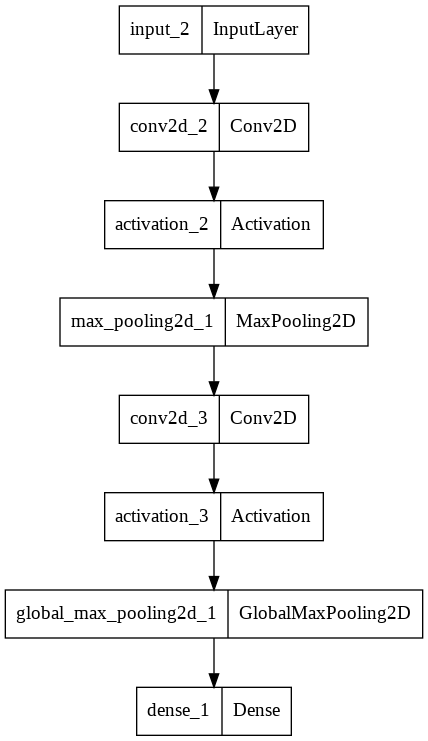

In [ ]:
# Architecture plot
keras.utils.plot_model(net1)

In [ ]:
# Network compilation
net1.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =keras.metrics.CategoricalAccuracy())

In [ ]:
# Training
history = net1.fit(x = train_images,
                   y = one_hot_encoded_train_labels,
                   batch_size = 100,
                   epochs = 50,
                   validation_data = (valid_images, one_hot_encoded_val_labels));

Epoch 1/50
51/51 [==============================] - 20s 188ms/step - loss: 5.5336 - categorical_accuracy: 0.0026 - val_loss: 5.5249 - val_categorical_accuracy: 0.0040
Epoch 2/50
51/51 [==============================] - 7s 145ms/step - loss: 5.5260 - categorical_accuracy: 0.0046 - val_loss: 5.5235 - val_categorical_accuracy: 0.0040
Epoch 3/50
51/51 [==============================] - 8s 148ms/step - loss: 5.5209 - categorical_accuracy: 0.0060 - val_loss: 5.5166 - val_categorical_accuracy: 0.0064
Epoch 4/50
51/51 [==============================] - 8s 149ms/step - loss: 5.5068 - categorical_accuracy: 0.0054 - val_loss: 5.5022 - val_categorical_accuracy: 0.0072
Epoch 5/50
51/51 [==============================] - 8s 152ms/step - loss: 5.4847 - categorical_accuracy: 0.0092 - val_loss: 5.4860 - val_categorical_accuracy: 0.0056
Epoch 6/50
51/51 [==============================] - 8s 150ms/step - loss: 5.4591 - categorical_accuracy: 0.0100 - val_loss: 5.4723 - val_categorical_accuracy: 0.0080
Epo

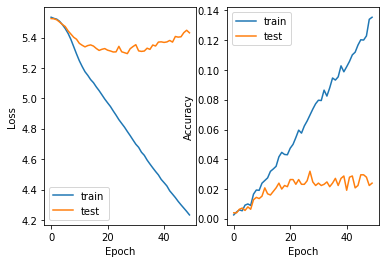

In [ ]:
# Learning curves visualization

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance sono molto basse sia sul training che sul validation. Sul training si ha un valore di accuracy del 13% e sul validation non si raggiunge neanche il 10%. Prima di tutto si cercano di migliorare le performance sul training set. 

Si aggiunge un layer di batch normalization prima del layer di max pooling.

In [ ]:
# Saving
net1.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv1.h5')

### 2. **Model v2**

**Architettura - Model V2**

* Input Layer
* 2d Convolutional layer (3x3 filter, x32)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, x64)
* Relu activation
* Batch Normalization layer
* Global Max Pooling layer
* Dense layer (Softmax Activation)

In [ ]:
# Architecture definition
inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)
net2 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary
net2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496 

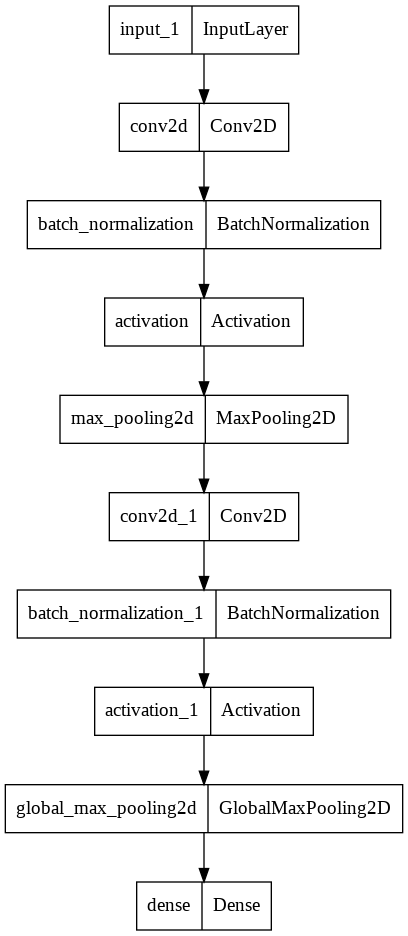

In [ ]:
# Architecture plot
keras.utils.plot_model(net2)

In [ ]:
# Network Compilation
net2.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =keras.metrics.CategoricalAccuracy())

In [ ]:
# Training
history2 = net2.fit(x = train_images,
                    y = one_hot_encoded_train_labels,
                    batch_size = 100,
                    epochs = 50,
                    validation_data = (valid_images, one_hot_encoded_val_labels));

Epoch 1/50
51/51 [==============================] - 22s 234ms/step - loss: 5.8847 - categorical_accuracy: 0.0032 - val_loss: 5.5406 - val_categorical_accuracy: 0.0064
Epoch 2/50
51/51 [==============================] - 10s 195ms/step - loss: 5.5677 - categorical_accuracy: 0.0044 - val_loss: 5.5426 - val_categorical_accuracy: 0.0056
Epoch 3/50
51/51 [==============================] - 10s 201ms/step - loss: 5.5490 - categorical_accuracy: 0.0034 - val_loss: 5.5406 - val_categorical_accuracy: 0.0056
Epoch 4/50
51/51 [==============================] - 10s 200ms/step - loss: 5.5292 - categorical_accuracy: 0.0048 - val_loss: 5.5366 - val_categorical_accuracy: 0.0048
Epoch 5/50
51/51 [==============================] - 10s 197ms/step - loss: 5.5140 - categorical_accuracy: 0.0066 - val_loss: 5.5266 - val_categorical_accuracy: 0.0064
Epoch 6/50
51/51 [==============================] - 10s 195ms/step - loss: 5.4829 - categorical_accuracy: 0.0092 - val_loss: 5.5080 - val_categorical_accuracy: 0.011

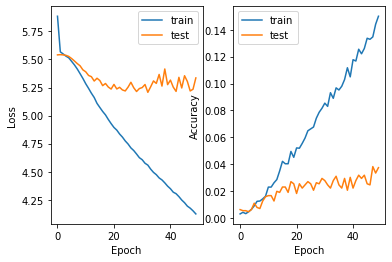

In [ ]:
# Learning curves visualization

# Loss
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance sono molto simili al modello precedente. Si decide di aumentare la complessità della rete, inserendo un nuovo blocco convoluzionale.

In [ ]:
# Saving 
net2.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv2.h5')

### 3. **Model v3**

**Architettura - Model V3**

* Input Layer
* 2d Convolutional layer (3x3 filter, x32)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, x64)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d Convolutional layer (3x3 filter, x128)
* Relu activation
* Batch Normalization layer
* Global Max Pooling layer
* Dense layer (Softmax Activation)

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)
net3 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary
net3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 64)        1849

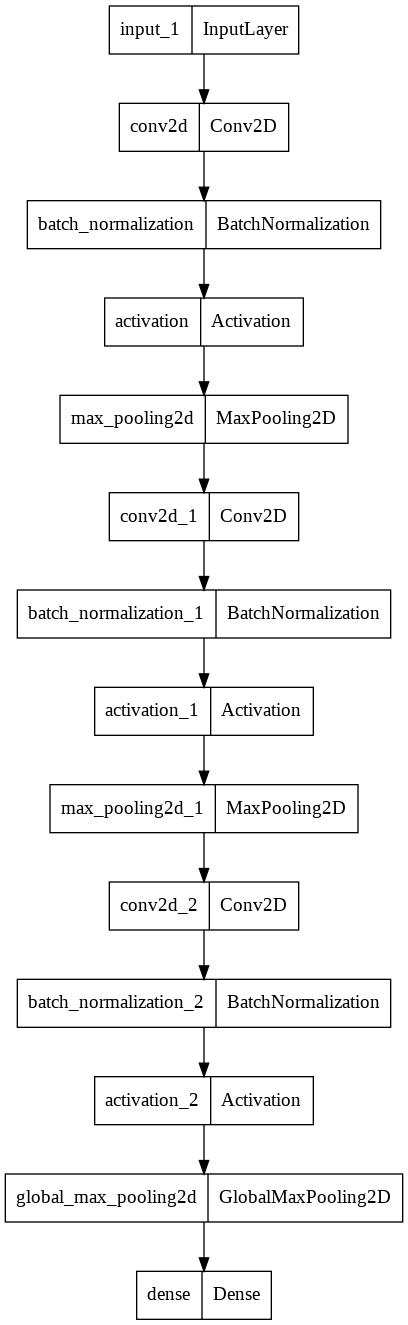

In [ ]:
# Architecture plot
keras.utils.plot_model(net3)

In [ ]:
# Network compilation
net3.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =['categorical_accuracy'])

In [ ]:
# Training
history3 = net3.fit(x = train_images,
                    y = one_hot_encoded_train_labels,
                    batch_size = 100,
                    epochs = 50,
                    validation_data = (valid_images, one_hot_encoded_val_labels))

Epoch 1/50
51/51 [==============================] - 24s 252ms/step - loss: 5.8862 - categorical_accuracy: 0.0044 - val_loss: 5.5504 - val_categorical_accuracy: 0.0048
Epoch 2/50
51/51 [==============================] - 10s 204ms/step - loss: 5.5325 - categorical_accuracy: 0.0078 - val_loss: 5.5846 - val_categorical_accuracy: 0.0072
Epoch 3/50
51/51 [==============================] - 10s 205ms/step - loss: 5.4522 - categorical_accuracy: 0.0131 - val_loss: 5.6265 - val_categorical_accuracy: 0.0040
Epoch 4/50
51/51 [==============================] - 10s 206ms/step - loss: 5.3456 - categorical_accuracy: 0.0207 - val_loss: 5.6680 - val_categorical_accuracy: 0.0048
Epoch 5/50
51/51 [==============================] - 10s 205ms/step - loss: 5.2432 - categorical_accuracy: 0.0293 - val_loss: 5.6823 - val_categorical_accuracy: 0.0048
Epoch 6/50
51/51 [==============================] - 11s 207ms/step - loss: 5.1418 - categorical_accuracy: 0.0349 - val_loss: 5.7652 - val_categorical_accuracy: 0.004

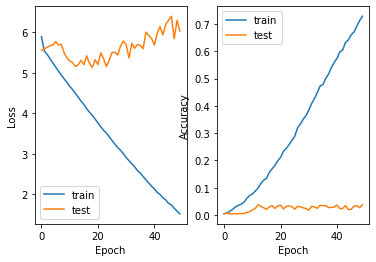

In [ ]:
# Learning curves visualization

# Loss
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance aumentano notevolmente sul dataset di training. Si ottiene un valore di accuracy del 75%. Le performance sul validation rimangono sempre molto basse, non riuscendo a raggiungere neanche il 10%. Ci troviamo in una situazione di overfitting. 

Nel prossimo modello decidiamo di mantenere la complessità della rete appena allenata, aggiungendo nello strato convoluzionale un termine di regolarizzazione. 

In [ ]:
# Saving
net3.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv3.h5')

### 4. **Model v4** include 3 modelli

#### 4l1. **Model v4l1: lasso regularization**

**Architecture Model V4l1**

* Input Layer
* 2d Convolutional layer (3x3 filter, x32, lasso regularizer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, x64, lasso regularizer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d Convolutional layer (3x3 filter, x128, lasso regularizer)
* Relu activation
* Batch Normalization layer
* Global Max Pooling layer
* Dense layer (Softmax Activation, lasso regularizer)

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l1(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l1(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l1(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
net4l1 = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [ ]:
# Architecture summary
net4l1.summary()

<IPython.core.display.Javascript object>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 64)        1849

<IPython.core.display.Javascript object>

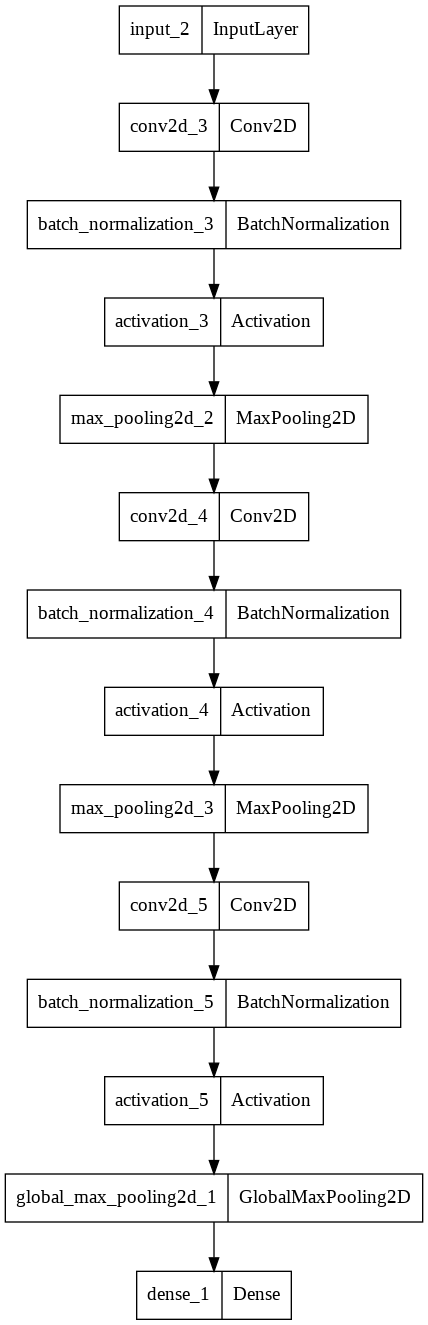

In [ ]:
# Architecture plot
keras.utils.plot_model(net4l1)

In [ ]:
# Compilazione di v4 lasso per addestramento
net4l1.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
               metrics =['categorical_accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# Training
history4l1 = net4l1.fit(x = train_images,
                        y = one_hot_encoded_train_labels,
                        batch_size = 100,
                        epochs = 50,
                        validation_data = (valid_images, one_hot_encoded_val_labels));

<IPython.core.display.Javascript object>

Epoch 1/50
51/51 [==============================] - 19s 240ms/step - loss: 10.3270 - categorical_accuracy: 0.0038 - val_loss: 9.4719 - val_categorical_accuracy: 0.0064
Epoch 2/50
51/51 [==============================] - 10s 200ms/step - loss: 8.9737 - categorical_accuracy: 0.0076 - val_loss: 8.5478 - val_categorical_accuracy: 0.0040
Epoch 3/50
51/51 [==============================] - 10s 201ms/step - loss: 8.1356 - categorical_accuracy: 0.0125 - val_loss: 7.9839 - val_categorical_accuracy: 0.0040
Epoch 4/50
51/51 [==============================] - 10s 203ms/step - loss: 7.6290 - categorical_accuracy: 0.0173 - val_loss: 7.6580 - val_categorical_accuracy: 0.0032
Epoch 5/50
51/51 [==============================] - 10s 202ms/step - loss: 7.2774 - categorical_accuracy: 0.0225 - val_loss: 7.4562 - val_categorical_accuracy: 0.0040
Epoch 6/50
51/51 [==============================] - 10s 203ms/step - loss: 7.0428 - categorical_accuracy: 0.0241 - val_loss: 7.3199 - val_categorical_accuracy: 0.00

<IPython.core.display.Javascript object>

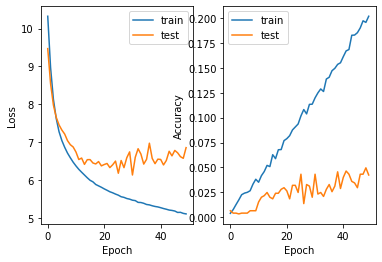

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(history4l1.history['loss'])
plt.plot(history4l1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history4l1.history['categorical_accuracy'])
plt.plot(history4l1.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
# Saving

net4l1.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv4l1.h5')

<IPython.core.display.Javascript object>

#### 4l2. **Model v4l2: ridge regularization**

**Architecture Model V4l2**

* Input Layer
* 2d Convolutional layer (3x3 filter, x32, ridge regularizer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, x64, ridge regularizer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d Convolutional layer (3x3 filter, x128, ridge regularizer)
* Relu activation
* Batch Normalization layer
* Global Max Pooling layer
* Dense layer (Softmax Activation, ridge regularizer)

In [ ]:
num_classes = 251

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net4l2 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary
net4l2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 64)        18496 

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net4l2 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary
net4l2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 86, 86, 64)        1849

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(128, strides = 128, padding = 'same')(x)
# global max pooling 2d = max pooling con dim dell'immagine
x = keras.layers.Flatten()(x)
# con il flatten ottengo il global max pooling finale

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net4l2 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary
net4l2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_21 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 86, 86, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 86, 86, 64)        1849

<IPython.core.display.Javascript object>

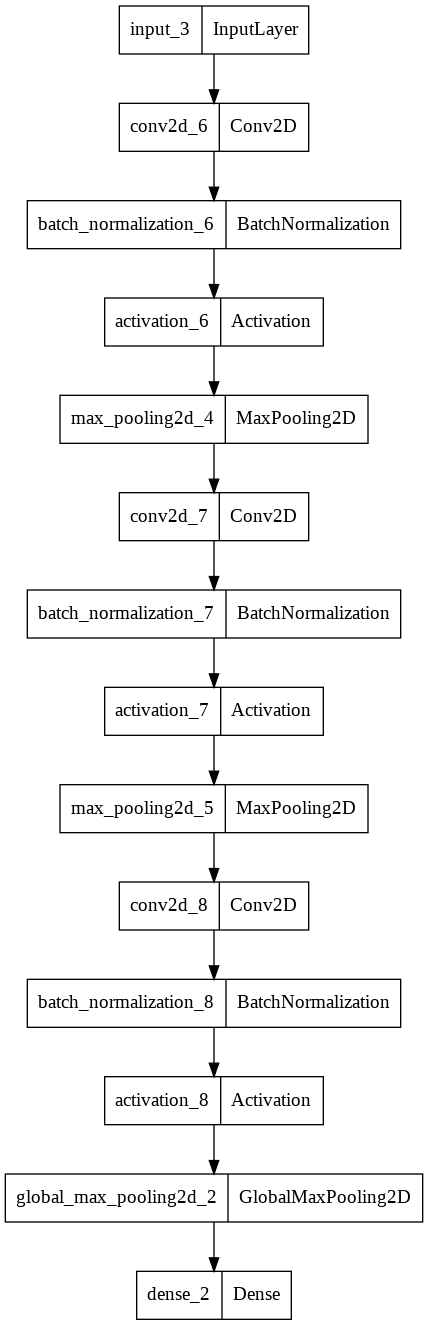

In [ ]:
# Architecture plot
keras.utils.plot_model(net4l2)

In [ ]:
# Network compilation
net4l2.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
               metrics =['categorical_accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# Training
history4l2 = net4l2.fit(x = train_images,
                      y = one_hot_encoded_train_labels,
                      batch_size = 100,
                      epochs = 50,
                      validation_data = (valid_images, one_hot_encoded_val_labels));

<IPython.core.display.Javascript object>

Epoch 1/50
51/51 [==============================] - 13s 227ms/step - loss: 6.1327 - categorical_accuracy: 0.0054 - val_loss: 5.8618 - val_categorical_accuracy: 0.0040
Epoch 2/50
51/51 [==============================] - 10s 202ms/step - loss: 5.8227 - categorical_accuracy: 0.0082 - val_loss: 5.8849 - val_categorical_accuracy: 0.0056
Epoch 3/50
51/51 [==============================] - 10s 202ms/step - loss: 5.7356 - categorical_accuracy: 0.0096 - val_loss: 5.9208 - val_categorical_accuracy: 0.0064
Epoch 4/50
51/51 [==============================] - 10s 203ms/step - loss: 5.6271 - categorical_accuracy: 0.0173 - val_loss: 5.9719 - val_categorical_accuracy: 0.0040
Epoch 5/50
51/51 [==============================] - 10s 203ms/step - loss: 5.5192 - categorical_accuracy: 0.0235 - val_loss: 5.9793 - val_categorical_accuracy: 0.0048
Epoch 6/50
51/51 [==============================] - 10s 205ms/step - loss: 5.4078 - categorical_accuracy: 0.0343 - val_loss: 5.9539 - val_categorical_accuracy: 0.007

<IPython.core.display.Javascript object>

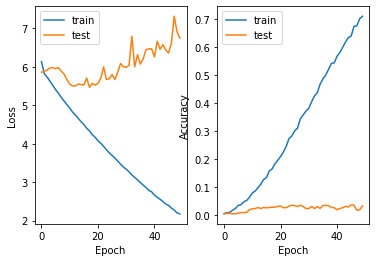

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(history4l2.history['loss'])
plt.plot(history4l2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history4l2.history['categorical_accuracy'])
plt.plot(history4l2.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance sono molto simile al modello v3. In questo caso si ottengono delle performance migliori sul training set con l'uso della regolarizzazione ridge rispetto alla regolarizzazione lasso. 

Decidiamo di fare una prova aumentando la complessità della rete, aggiungendo un layer fully connected composto da 64 neuroni nascosti. 

In [ ]:
# Saving

net4l2.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv4l2.h5')

<IPython.core.display.Javascript object>

### 5. **Model v4_5**

Si aggiunge un **dense layer** composto da 64 neuroni nascosti.

**Architecture Model V4_5**

* Input Layer
* 2d Convolutional layer (3x3 filter, x32, ridge regularizer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, x64, ridge regularizer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d Convolutional layer (3x3 filter, x128, ridge regularizer)
* Relu activation
* Batch Normalization layer
* Global Max Pooling layer
* Dense layer (x64, Softmax Activation, ridge regularizer)
* Dense layer (Softmax Activation, ridge regularizer)

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net4_5 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary

net4_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496 

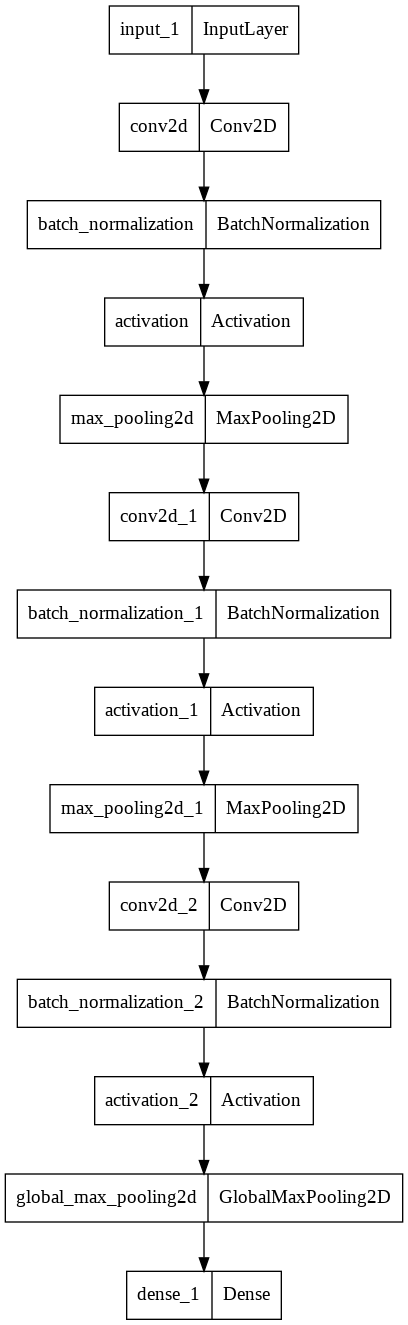

In [ ]:
# Architecture plot

keras.utils.plot_model(net4_5)

In [ ]:
# Network compilation

net4_5.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
               metrics =['categorical_accuracy'])

In [ ]:
# Training

history4_5 = net4_5.fit(x = train_images,
                      y = one_hot_encoded_train_labels,
                      batch_size = 100,
                      epochs = 50,
                      validation_data = (valid_images, one_hot_encoded_val_labels));

Epoch 1/50
51/51 [==============================] - 23s 244ms/step - loss: 6.1437 - categorical_accuracy: 0.0028 - val_loss: 5.8478 - val_categorical_accuracy: 0.0040
Epoch 2/50
51/51 [==============================] - 10s 206ms/step - loss: 5.8386 - categorical_accuracy: 0.0094 - val_loss: 5.8588 - val_categorical_accuracy: 0.0040
Epoch 3/50
51/51 [==============================] - 10s 206ms/step - loss: 5.7415 - categorical_accuracy: 0.0114 - val_loss: 5.8712 - val_categorical_accuracy: 0.0048
Epoch 4/50
51/51 [==============================] - 11s 210ms/step - loss: 5.6256 - categorical_accuracy: 0.0161 - val_loss: 5.8859 - val_categorical_accuracy: 0.0088
Epoch 5/50
51/51 [==============================] - 11s 209ms/step - loss: 5.5132 - categorical_accuracy: 0.0301 - val_loss: 5.8841 - val_categorical_accuracy: 0.0056
Epoch 6/50
51/51 [==============================] - 10s 206ms/step - loss: 5.4111 - categorical_accuracy: 0.0333 - val_loss: 5.9018 - val_categorical_accuracy: 0.005

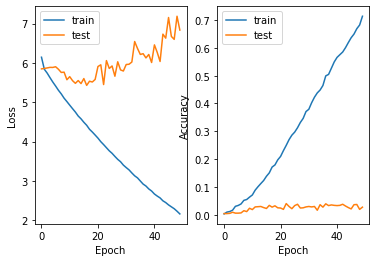

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(history4_5.history['loss'])
plt.plot(history4_5.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history4_5.history['categorical_accuracy'])
plt.plot(history4_5.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Performance molto simili al modello precedente. 
Come ulteriore prova, aggiungiamo un nuovo strato fully connected composto da 128 neuroni nascosti. 

In [ ]:
# Saving
net4_5.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv4_5.h5')

### 6. **Model v5**

Aggiungiamo un **dense layer** composto da 128 neuroni nascosti, prima di quello composto da 64 neuroni nascosti. In totale, la sezione cfully connected della rete è composta da 3 dense layer (l'ultimo è lo strato di output).

**Architettura Model V5**

* Input Layer
* 2d Convolutional layer (3x3 filter, x32, ridge regularizer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, x64, ridge regularizer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d Convolutional layer (3x3 filter, x128, ridge regularizer)
* Relu activation
* Batch Normalization layer
* Global Max Pooling layer
* Dense layer (x128, Softmax Activation, ridge regularizer)
* Dense layer (x64, Softmax Activation, ridge regularizer)
* Dense layer (Softmax Activation, ridge regularizer)

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(128, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net5 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary

net5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496 

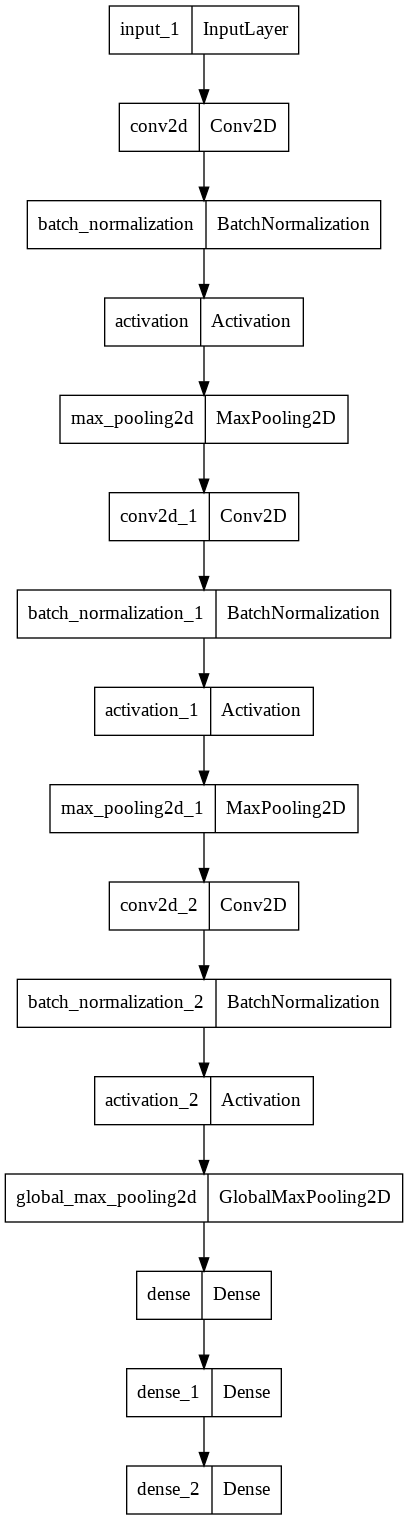

In [ ]:
# Architecture plot

keras.utils.plot_model(net5)

In [ ]:
# Network compilation

net5.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =['categorical_accuracy'])

In [ ]:
# Training

history5 = net5.fit(x = train_images,
                      y = one_hot_encoded_train_labels,
                      batch_size = 100,
                      epochs = 50,
                      validation_data = (valid_images, one_hot_encoded_val_labels));

Epoch 1/50
51/51 [==============================] - 19s 240ms/step - loss: 5.9414 - categorical_accuracy: 0.0052 - val_loss: 5.8501 - val_categorical_accuracy: 0.0032
Epoch 2/50
51/51 [==============================] - 10s 205ms/step - loss: 5.8014 - categorical_accuracy: 0.0060 - val_loss: 5.7651 - val_categorical_accuracy: 0.0048
Epoch 3/50
51/51 [==============================] - 10s 203ms/step - loss: 5.6812 - categorical_accuracy: 0.0086 - val_loss: 5.7429 - val_categorical_accuracy: 0.0040
Epoch 4/50
51/51 [==============================] - 10s 203ms/step - loss: 5.5548 - categorical_accuracy: 0.0118 - val_loss: 5.8256 - val_categorical_accuracy: 0.0040
Epoch 5/50
51/51 [==============================] - 10s 201ms/step - loss: 5.4364 - categorical_accuracy: 0.0175 - val_loss: 5.8444 - val_categorical_accuracy: 0.0040
Epoch 6/50
51/51 [==============================] - 10s 202ms/step - loss: 5.3353 - categorical_accuracy: 0.0259 - val_loss: 6.0719 - val_categorical_accuracy: 0.004

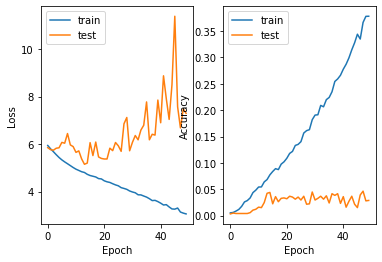

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history5.history['categorical_accuracy'])
plt.plot(history5.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance sono diminuite. Riteniamo che il modello sia troppo complesso nella sezione fully connected, di conseguenza riteniamo migliore il modello precedente. 

Decidiamo di mantenere il modello con 3 blocchi convoluzionali e un solo strato dense di output. Cambiamo l'algoritmo di inizializzazione dei pesi da Xavier a He. 

In [ ]:
# Saving

net5.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv5.h5')

### 7. **Model v6**

Cambiamo l'algoritmo di **inizializzazione dei pesi** negli strati convoluzionali. Inseriamo l'inizializzatore **He** perché potrebbe funzionare meglio negli strati convoluzionali in cui la funzione di attivazione è una ReLU.

**Architettura Model V6**

* Input Layer
* 2d Convolutional layer (3x3 filter, x32, ridge regularizer, He uniform inizializer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, x64, ridge regularizer, He uniform inizializer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d Convolutional layer (3x3 filter, x128, ridge regularizer, He uniform inizializer)
* Relu activation
* Batch Normalization layer
* Global Max Pooling layer
* Dense layer (Softmax Activation, ridge regularizer)

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net6 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary

net6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496 

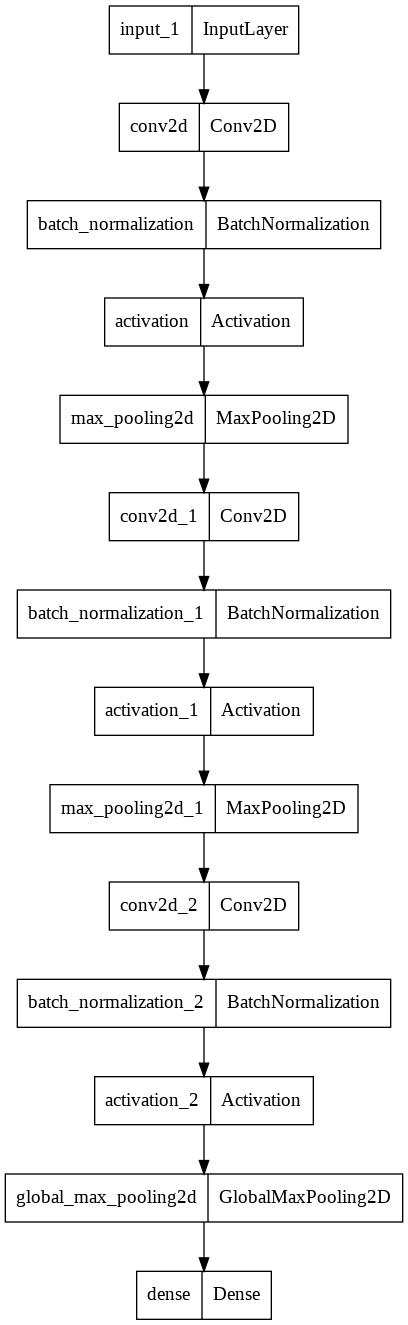

In [ ]:
# Architecture Plot

keras.utils.plot_model(net6)

In [ ]:
# Network compilation

net6.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =['categorical_accuracy'])

In [ ]:
# Training

history6 = net6.fit(x = train_images,
                      y = one_hot_encoded_train_labels,
                      batch_size = 100,
                      epochs = 50,
                      validation_data = (valid_images, one_hot_encoded_val_labels));

Epoch 1/50
51/51 [==============================] - 17s 241ms/step - loss: 6.5212 - categorical_accuracy: 0.0056 - val_loss: 6.3087 - val_categorical_accuracy: 0.0040
Epoch 2/50
51/51 [==============================] - 11s 206ms/step - loss: 6.1225 - categorical_accuracy: 0.0080 - val_loss: 6.1268 - val_categorical_accuracy: 0.0040
Epoch 3/50
51/51 [==============================] - 11s 209ms/step - loss: 5.9816 - categorical_accuracy: 0.0133 - val_loss: 6.0554 - val_categorical_accuracy: 0.0112
Epoch 4/50
51/51 [==============================] - 10s 205ms/step - loss: 5.8449 - categorical_accuracy: 0.0213 - val_loss: 6.0161 - val_categorical_accuracy: 0.0040
Epoch 5/50
51/51 [==============================] - 10s 204ms/step - loss: 5.7232 - categorical_accuracy: 0.0281 - val_loss: 5.9719 - val_categorical_accuracy: 0.0104
Epoch 6/50
51/51 [==============================] - 10s 205ms/step - loss: 5.6123 - categorical_accuracy: 0.0351 - val_loss: 5.9080 - val_categorical_accuracy: 0.011

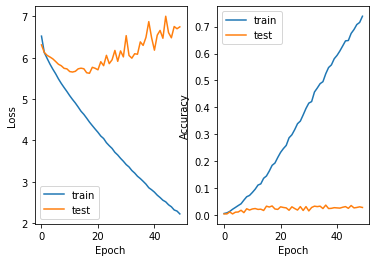

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history6.history['categorical_accuracy'])
plt.plot(history6.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance aumentano di qualche punto percentuale sul dataset di training, raggiungendo un valore di categorical accuracy pari al 74%. Siamo sempre in una situazione di overfitting perchè le performance sul validation rimangono sempre molto basse e pari al 3%. 

Aggiungiamo la callback *Reduce Learning Rate*. 

In [ ]:
# Saving
net6.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv6.h5')

### 8. **Model v7**

Aggiungiamo la callback **Reduce learning rate on plateau**. I modelli spesso traggono beneficio dalla riduzione del tasso di apprendimento una volta che l'apprendimento ristagna. Questo callback monitora le metriche e se non si vedono miglioramenti per un numero 'patience' di epoche, il tasso di apprendimento viene ridotto.

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
net7 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary

net7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496 

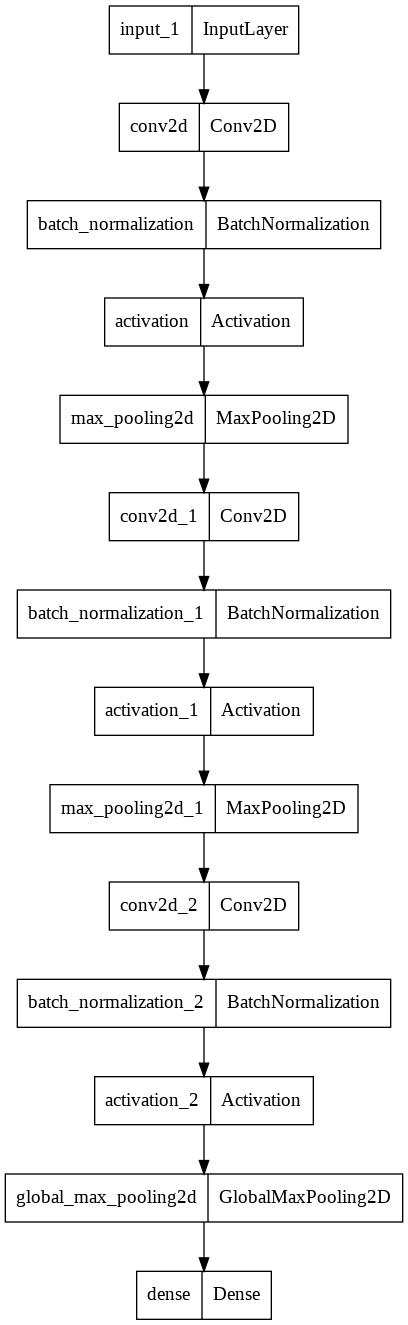

In [ ]:
# Architecture plot

keras.utils.plot_model(net7)

In [ ]:
# Network Compilation

net7.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =['categorical_accuracy'])

In [ ]:
# Reduce Learning Rate

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode='min',patience=3, 
                              verbose=1, factor=0.5, min_lr=0.000001)

In [ ]:
# Training

history7 = net7.fit(x = train_images,
                    y = one_hot_encoded_train_labels,
                    batch_size = 100,
                    epochs = 50,
                    validation_data = (valid_images, one_hot_encoded_val_labels),
                    callbacks = [reduce_lr]);

Epoch 1/50
51/51 [==============================] - 17s 238ms/step - loss: 11.1269 - categorical_accuracy: 0.0038 - val_loss: 9.9356 - val_categorical_accuracy: 0.0072 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 10s 204ms/step - loss: 9.2386 - categorical_accuracy: 0.0064 - val_loss: 8.6360 - val_categorical_accuracy: 0.0040 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 10s 204ms/step - loss: 8.1024 - categorical_accuracy: 0.0143 - val_loss: 7.8359 - val_categorical_accuracy: 0.0048 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 10s 202ms/step - loss: 7.3624 - categorical_accuracy: 0.0189 - val_loss: 7.3207 - val_categorical_accuracy: 0.0048 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 10s 202ms/step - loss: 6.8630 - categorical_accuracy: 0.0235 - val_loss: 7.0003 - val_categorical_accuracy: 0.0064 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 10s 201ms/step - loss: 6.5019 - categorical_acc

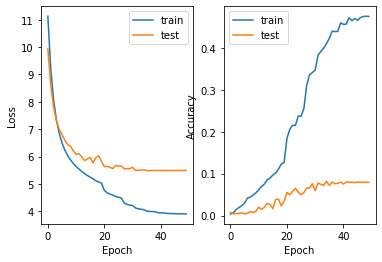

In [ ]:
# Learning curves visualition

plt.subplot(1, 2, 1)
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history7.history['categorical_accuracy'])
plt.plot(history7.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In questo caso le performance non sono migliorate. Il modello migliore rimane il modello v6. 

In [ ]:
# Saving

net7.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv7.h5')

### 9. **Model v8**

Una pratica per ridurre l'overfitting è aggiungere dei layer di **dropout**. Il layer Dropout imposta casualmente a 0 le unità di input con una frequenza pari a `rate` ad ogni passo durante il training, in modo da evitare l'overfitting. Gli imput non impostati a 0 vengono scalati di 1/(1 - `rate`) in modo che la somma di tutti gli ingressi rimanga invariata.

**Architettura Model V6**

* Input Layer
* 2d Convolutional layer (3x3 filter, x32, ridge regularizer, He uniform inizializer)
* Relu activation
* Dropout layer
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, x64, ridge regularizer, He uniform inizializer)
* Relu activation
* Dropout layer
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d Convolutional layer (3x3 filter, x128, ridge regularizer, He uniform inizializer)
* Relu activation
* Dropout layer
* Batch Normalization layer
* Global Max Pooling layer
* Dense layer (Softmax Activation, ridge regularizer)

In [ ]:
# Architecture definition

inputs = keras.Input((256, 256, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net8 = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary

net8.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496 

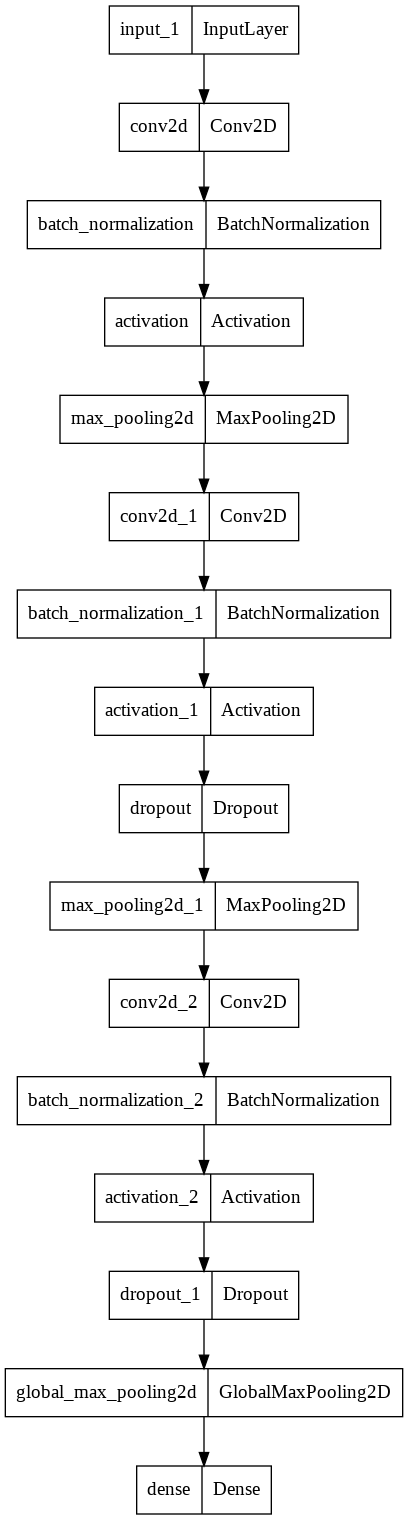

In [ ]:
# Architecture Plot

keras.utils.plot_model(net8)

In [ ]:
# Network compilation

net8.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =['categorical_accuracy'])

In [ ]:
# Training

history8 = net8.fit(x = train_images,
                      y = one_hot_encoded_train_labels,
                      batch_size = 100,
                      epochs = 50,
                      validation_data = (valid_images, one_hot_encoded_val_labels));

Epoch 1/50
51/51 [==============================] - 18s 254ms/step - loss: 6.6236 - categorical_accuracy: 0.0046 - val_loss: 6.2173 - val_categorical_accuracy: 0.0056
Epoch 2/50
51/51 [==============================] - 11s 214ms/step - loss: 6.1515 - categorical_accuracy: 0.0088 - val_loss: 6.1150 - val_categorical_accuracy: 0.0072
Epoch 3/50
51/51 [==============================] - 11s 216ms/step - loss: 6.0248 - categorical_accuracy: 0.0118 - val_loss: 6.0589 - val_categorical_accuracy: 0.0048
Epoch 4/50
51/51 [==============================] - 11s 217ms/step - loss: 5.8981 - categorical_accuracy: 0.0201 - val_loss: 6.0278 - val_categorical_accuracy: 0.0072
Epoch 5/50
51/51 [==============================] - 11s 218ms/step - loss: 5.7683 - categorical_accuracy: 0.0271 - val_loss: 5.9581 - val_categorical_accuracy: 0.0088
Epoch 6/50
51/51 [==============================] - 11s 219ms/step - loss: 5.6633 - categorical_accuracy: 0.0295 - val_loss: 5.9106 - val_categorical_accuracy: 0.006

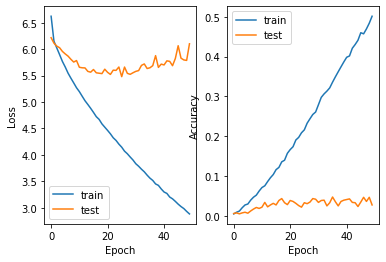

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history8.history['categorical_accuracy'])
plt.plot(history8.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance non migliorano. 

In [ ]:
# Saving
net8.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv8.h5')

## 5) **Transfer Learning**

Come detto precedentemente, proponiamo diverse **Reti preaddestrate** su Imagenet. Utilizziamo sia il fine-tuning che la feature extraction. Per qil fine-tuning proponiamo diverse modelli utilizzando la ***ResNet50*** e la ***MobileNetV2***. Per la feature extraction decidiamo di estrarre features da due differenti layer della MobileNetV2. 

Tutti i modelli vengono salvati nella cartella *Models* per permettere in futuro la classificazione su immagini di test.

**Step principali**

Gli step principali per definire una rete neurale sono i seguenti:

1.	Definizione dell'architettura
2.	Compilazione: definizione dei macroelementi della rete (ottimizzatore, tasso di apprendimento nell'ottimizzatore (learning rate), funzione di perdita, metriche aggiuntive, parametri aggiuntivi, ecc.) 
4.	Addestramento (epoche, dimensione del batch, ecc.).
5.	Riassunto (summary) e visualizzazione dei risultati

In generale, le impostazioni sono le seguenti:

**Compilazione** 
* ottimizzatore: RMSprop
* funzione di perdita: categorical crossentropy
* metrica: categorical accuracy

**Fitting**
* batch size: dipende
* epoche: dipende

### 5.1) **Fine-Tuning ResNet50**

In [ ]:
num_classes = 251

In [ ]:
ResNet50_V1 = keras.applications.ResNet50(input_shape=(224,224,3), 
                                          weights='imagenet', 
                                          include_top=False, # do not include the fully-connected layer at the top of the network
                                          pooling='avg')

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
print('Numero layers ResNet50: {}'.format(len(ResNet50_V1.layers)))


Numero layers ResNet50: 176


In [ ]:
ResNet50_V1.layers

#### 5.1.1) **Data Loader ResNet50**

**Import file con labels**

In [ ]:
train_labels = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/train_info_100fin.csv')
val_labels = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/val_info_20fin.csv')

In [ ]:
train_labels

In [ ]:
train_labels = train_labels[['Name', 'Class']]
val_labels = val_labels[['Name', 'Class']]

In [ ]:
train_labels

In [ ]:
val_labels

**Training Preprocess Resnet50**

In [ ]:
train_path = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Train/'
val_path = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Validation/'

In [ ]:
i = 0
for im in os.listdir(train_path):
  i+=1
i
#25034

In [ ]:
i = 0
for im in os.listdir(val_path):
  i+=1
i
#4979

In [ ]:
train_images = []
for image_file in os.listdir(train_path):
    image = Image.open(train_path+image_file)
    newsize = (224, 224)
    image = image.resize(newsize)
    image = np.array(image)
    image = tf.keras.applications.resnet50.preprocess_input(image) # preprocessing Resnet50
    train_images.append(image)

# Converte la lista di immagini in una matrice NumPy
train_images = np.stack(train_images)

print(train_images.shape)

**Training labels**

In [ ]:
one_hot_encoded_train_labels = tf.keras.utils.to_categorical(train_labels)
len(one_hot_encoded_train_labels)

7530

**Validation Preprocess Resnet50**

In [ ]:
valid_images = []
for image_file in os.listdir(val_path):
    image = Image.open(val_path+image_file)
    newsize = (224, 224)
    image = image.resize(newsize)
    image = np.array(image)
    image = tf.keras.applications.resnet50.preprocess_input(image) 
    valid_images.append(image)

# Converte la lista di immagini in una matrice NumPy
valid_images = np.stack(valid_images)

print(valid_images.shape)  # Stampa le dimensioni della matrice (numero di immagini, altezza, larghezza, canali)

**Validation Labels**

In [ ]:
one_hot_encoded_val_labels = tf.keras.utils.to_categorical(val_labels)
len(one_hot_encoded_val_labels)

2252

#### 5.1.2) **ResNet50 V1**

Nella prima versione decidiamo di congelare tutti i layer della rete ResNet50 e di aggiungere due strati dense e due di dropout. In questo modo il numero di pesi da allenare riduce drasticamente. I tempi computazionali diminuiscono e le performance dovrebbero crescere leggermente.

Dopo il modello di base viene aggiunto un FFN costruito con i seguenti strati:

- Dense layer (x128, Relu Activation)
- Dropout layer (0.2)
- Dense layer (x64, Relu Activation)
- Dropout layer (0.2)
- Output layer (x251, Softmax Activation)

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in ResNet50_V1.layers])

# Freeze all layers
for layer in ResNet50_V1.layers:
    layer.trainable = False # Freeze tutti i layer

In [ ]:
x1 = ResNet50_V1.output
x1 = keras.layers.Dense(128, activation = 'relu')(x1)
x1 = keras.layers.Dropout(0.2)(x1)
x1 = keras.layers.Dense(64, activation='relu')(x1)
x1 = keras.layers.Dropout(0.2)(x1)
pred1 = keras.layers.Dense(num_classes, activation = 'softmax')(x1)

In [ ]:
model1 =  keras.Model(inputs=ResNet50_V1.input, outputs=pred1)

In [ ]:
model1.summary()

<IPython.core.display.Javascript object>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model1.compile(
  optimizer=keras.optimizers.RMSprop(),
  loss = keras.losses.categorical_crossentropy,
  metrics=['categorical_accuracy'])

In [ ]:
historynet_ResNetV1 = model1.fit(x = train_images,
                                 y = train_labels,
                                 batch_size = 128,
                                 epochs = 50,
                                 validation_data = (valid_images, val_labels));

Epoch 1/50
98/98 [==============================] - 98s 931ms/step - loss: 5.4989 - categorical_accuracy: 0.0090 - val_loss: 5.3438 - val_categorical_accuracy: 0.0253
Epoch 2/50
98/98 [==============================] - 86s 878ms/step - loss: 5.1486 - categorical_accuracy: 0.0303 - val_loss: 4.8760 - val_categorical_accuracy: 0.0695
Epoch 3/50
98/98 [==============================] - 86s 881ms/step - loss: 4.7539 - categorical_accuracy: 0.0625 - val_loss: 4.5266 - val_categorical_accuracy: 0.1117
Epoch 4/50
98/98 [==============================] - 86s 882ms/step - loss: 4.4459 - categorical_accuracy: 0.0980 - val_loss: 4.2753 - val_categorical_accuracy: 0.1466
Epoch 5/50
98/98 [==============================] - 86s 884ms/step - loss: 4.2174 - categorical_accuracy: 0.1244 - val_loss: 4.1348 - val_categorical_accuracy: 0.1760

2023-01-15 15:41:04.230521: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-15 15:41:04.287244: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-15 17:55:48.879663: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7536635904 exceeds 10% of free system memory.
2023-01-15 17:55:53.101356: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7536635904 exceeds 10% of free system memory.
2023-01-15 17:56:00.004907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version

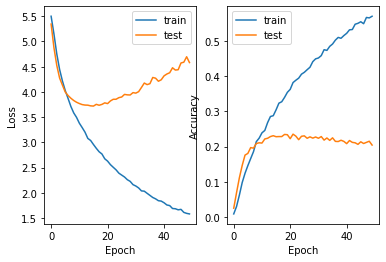

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(historynet_ResNetV1.history['loss'])
plt.plot(historynet_ResNetV1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(historynet_ResNetV1.history['categorical_accuracy'])
plt.plot(historynet_ResNetV1.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance del modello risultato essere le migliori tra tutti i modelli allenati. Abbiamo sempre una situazione di overfitting ma otteniamo un valore di categorical accuracy sul validation intorno al 23%. 

In [ ]:
model1.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv1_ResNet50.h5')

#### 5.1.3) **ResNet50 V2**

Nella seconda versione decidiamo di congelare tutti i layer della rete ResNet50 e di aggiungere una rete fully connected più profonda. 

Dopo il modello di base viene aggiunto un FFN costruito con i seguenti strati:

- Dense layer (x512, Relu Activation)
- Dense layer (x256, Relu Activation)
- Dropout layer (0.15)
- Dense layer (x128, Relu Activation)
- Dense layer (x64, Relu Activation)
- Dropout layer (0.15)
- Dense layer (x32, Relu Activation)
- Dense layer (x16, Relu Activation)
- Output layer (x251, Softmax Activation)

In [ ]:
x2 = ResNet50_V1.output
x2 = keras.layers.Dense(512,'relu')(x2)
x2 = keras.layers.Dense(256,'relu')(x2)
x2 = keras.layers.Dropout(.15)(x2)
x2 = keras.layers.Dense(128,'relu')(x2)
x2 = keras.layers.Dense(64,'relu')(x2)
x2 = keras.layers.Dropout(.15)(x2)
x2 = keras.layers.Dense(32,'relu')(x2)
x2 = keras.layers.Dense(16,'relu')(x2)
pred2 = keras.layers.Dense(num_classes,'softmax')(x2)

model2 =  keras.Model(inputs=ResNet50_V1.input, outputs=pred2)

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model2.compile(
  optimizer=keras.optimizers.RMSprop(),
  loss = keras.losses.categorical_crossentropy,
  metrics=['categorical_accuracy'])

In [ ]:
historynet_ResNetV2 = model2.fit(x = train_images,
                                 y = train_labels,
                                 batch_size = 128,
                                 epochs = 20,
                                 validation_data = (val_images,valid_labels));

2023-01-15 16:09:17.885926: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7536635904 exceeds 10% of free system memory.
2023-01-15 16:09:22.157933: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7536635904 exceeds 10% of free system memory.


Epoch 1/20
98/98 [==============================] - 95s 918ms/step - loss: 5.5267 - categorical_accuracy: 0.0035 - val_loss: 5.5026 - val_categorical_accuracy: 0.0064
Epoch 2/20
98/98 [==============================] - 87s 893ms/step - loss: 5.4103 - categorical_accuracy: 0.0084 - val_loss: 5.2380 - val_categorical_accuracy: 0.0129
Epoch 3/20
98/98 [==============================] - 87s 893ms/step - loss: 5.1596 - categorical_accuracy: 0.0191 - val_loss: 5.0668 - val_categorical_accuracy: 0.0257
Epoch 4/20
98/98 [==============================] - 87s 893ms/step - loss: 4.9547 - categorical_accuracy: 0.0269 - val_loss: 4.9742 - val_categorical_accuracy: 0.0366
Epoch 5/20
98/98 [==============================] - 88s 895ms/step - loss: 4.7736 - categorical_accuracy: 0.0427 - val_loss: 4.8200 - val_categorical_accuracy: 0.0462

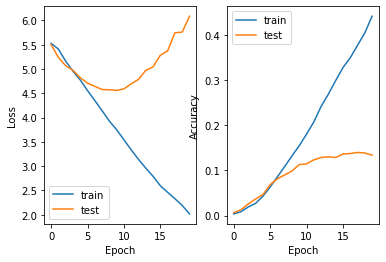

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(historynet_ResNetV2.history['loss'])
plt.plot(historynet_ResNetV2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(historynet_ResNetV2.history['categorical_accuracy'])
plt.plot(historynet_ResNetV2.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Performance diminuite, riteniamo migliore il modello precedente.

In [ ]:
model2.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv2_ResNet50.h5')

#### 5.1.4) **ResNet50 V3**

Nell'ultima versione decidiamo di congelare i layer fino al 143, così da allenare i pesi degli ultimi blocchi convoluzionali. Aggiungiamo sempre dei layer dense nell'ultima parte della rete. 

- Flatten layer 
- Dense layer (x128, Relu Activation)
- Dropou layer (0.2)
- Dense layer (x64, Relu Activation)
- Dropout layer (0.2)
- Output layer (x251, Softmax Activation)

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in ResNet50_V1.layers])

# Freeze all layers
for layer in ResNet50_V1_cut1.layers[:143]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(ResNet50_V1.layers):
  print(i, layer.name, '-', layer.trainable)

In [ ]:
x3 = ResNet50_V1.output
x3 = keras.layers.Flatten()(x3)
x3 = keras.layers.Dense(128, activation = 'relu')(x3)
x3 = keras.layers.Dropout(0.2)(x3)
x3 = keras.layers.Dense(64, activation='relu')(x3)
x3 = keras.layers.Dropout(0.2)(x3)
pred3 = keras.layers.Dense(num_classes, activation = 'softmax')(x3)

model3 =  keras.Model(inputs=ResNet50_V1.input, outputs=pred3)

In [ ]:
model3.summary()

In [ ]:
historynet_ResNetV3 = model3.fit(x = train_images,
                                 y = train_labels,
                                 batch_size = 128,
                                 epochs = 20,
                                 validation_data = (val_images, valid_labels));

2023-01-15 17:07:14.430479: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7536635904 exceeds 10% of free system memory.
2023-01-15 17:07:18.734494: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7536635904 exceeds 10% of free system memory.
2023-01-15 17:07:26.552538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2023-01-15 17:07:26.852396: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 17:07:30.006328: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x177c3720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-15 17:07:30.006369: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2023-01-15 17:07:30.012870: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, s

Epoch 1/20
98/98 [==============================] - 101s 944ms/step - loss: 5.1358 - categorical_accuracy: 0.0580 - val_loss: 4.4078 - val_categorical_accuracy: 0.1551
Epoch 2/20
98/98 [==============================] - 87s 889ms/step - loss: 3.8092 - categorical_accuracy: 0.2215 - val_loss: 3.9087 - val_categorical_accuracy: 0.2278
Epoch 3/20
98/98 [==============================] - 87s 889ms/step - loss: 3.1150 - categorical_accuracy: 0.3435 - val_loss: 3.7087 - val_categorical_accuracy: 0.2475
Epoch 4/20
98/98 [==============================] - 87s 889ms/step - loss: 2.5486 - categorical_accuracy: 0.4491 - val_loss: 3.5996 - val_categorical_accuracy: 0.2563
Epoch 5/20
98/98 [==============================] - 87s 890ms/step - loss: 2.0313 - categorical_accuracy: 0.5454 - val_loss: 3.6189 - val_categorical_accuracy: 0.2620

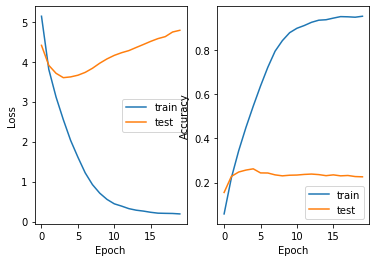

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(historynet_ResNetV3.history['loss'])
plt.plot(historynet_ResNetV3.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(historynet_ResNetV3.history['categorical_accuracy'])
plt.plot(historynet_ResNetV3.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
model3.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv3_ResNet50.h5')

### 5.2) **Fine-Tuning MobileNetV2**

#### 5.2.1) **Data Loader MobileNetV2**

**Import file con labels**

In [ ]:
train_labels = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/train_info_100fin.csv')
val_labels = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/val_info_20fin.csv')

In [ ]:
train_labels

In [ ]:
train_labels = train_labels[['Name', 'Class']]
val_labels = val_labels[['Name', 'Class']]

In [ ]:
train_labels

In [ ]:
val_labels

**Training Preprocess MobileNetV2**

In [ ]:
train_path = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Train/'
val_path = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Validation/'

In [ ]:
i = 0
for im in os.listdir(train_path):
  i+=1
i

In [ ]:
i = 0
for im in os.listdir(val_path):
  i+=1
i

In [ ]:
train_images = []
for image_file in os.listdir(train_path):
    image = Image.open(train_path+image_file)
    newsize = (224, 224)
    image = image.resize(newsize)
    image = np.array(image)
    image = f.keras.applications.mobilenet_v2.preprocess_input(image) # preprocessing Resnet50
    train_images.append(image)

# Converte la lista di immagini in una matrice NumPy
train_images = np.stack(train_images)

print(train_images.shape)

**Training labels**

In [ ]:
one_hot_encoded_train_labels = tf.keras.utils.to_categorical(train_labels)
len(one_hot_encoded_train_labels)

**Validation Preprocess MobileNetV2**

In [ ]:
valid_images = []
for image_file in os.listdir(val_path):
    image = Image.open(val_path+image_file)
    newsize = (224, 224)
    image = image.resize(newsize)
    image = np.array(image)
    image = f.keras.applications.mobilenet_v2.preprocess_input(image) 
    valid_images.append(image)

# Converte la lista di immagini in una matrice NumPy
valid_images = np.stack(valid_images)

print(valid_images.shape)  # Stampa le dimensioni della matrice (numero di immagini, altezza, larghezza, canali)

**Validation Labels**

In [ ]:
one_hot_encoded_val_labels = tf.keras.utils.to_categorical(val_labels)
len(one_hot_encoded_val_labels)

#### 5.2.2) **MobileNetV2 V1**

La versione 1 della MobileNetV2 è sviluppata nello stesso modo della versione 1 della ResNet50. 

In [ ]:
num_classes = 251

In [ ]:
MobNetV2_V1 = keras.applications.keras.applications.MobileNetV2(input_shape=(224,224,3), 
                                                                weights='imagenet', 
                                                                include_top=False, # do not include the fully-connected layer at the top of the network
                                                                pooling='avg')

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
print('Numero layers MobileNetV2: {}'.format(len(MobNetV2_V1.layers)))


Numero layers ResNet50: 176


In [ ]:
MobNetV2_V1.layers

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in MobNetV2_V1.layers])

# Freeze all layers
for layer in MobNetV2_V1.layers:
    layer.trainable = False

In [ ]:
x1 = MobNetV2_V1.output
x1 = keras.layers.Dense(128, activation = 'relu')(x1)
x1 = keras.layers.Dropout(0.2)(x1)
x1 = keras.layers.Dense(64, activation='relu')(x1)
x1 = keras.layers.Dropout(0.2)(x1)
pred1 = keras.layers.Dense(num_classes, activation = 'softmax')(x1)

In [ ]:
model1 =  keras.Model(inputs=ResNet50_V1.input, outputs=pred1)

In [ ]:
model1.summary()

<IPython.core.display.Javascript object>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model1.compile(
  optimizer=keras.optimizers.RMSprop(),
  loss = keras.losses.categorical_crossentropy,
  metrics=['categorical_accuracy'])

In [ ]:
historynet_MobNetV2_V1 = model1.fit(x = train_images,
                                    y = train_labels,
                                    batch_size = 128,
                                    epochs = 20,
                                    validation_data = (valid_images, valid_labels));

2023-01-15 19:57:04.955447: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7536635904 exceeds 10% of free system memory.
2023-01-15 19:57:18.858035: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7536635904 exceeds 10% of free system memory.


Epoch 1/20
98/98 [==============================] - 49s 409ms/step - loss: 5.4142 - categorical_accuracy: 0.0174 - val_loss: 5.0208 - val_categorical_accuracy: 0.0486
Epoch 2/20
98/98 [==============================] - 37s 376ms/step - loss: 4.6796 - categorical_accuracy: 0.0760 - val_loss: 4.3318 - val_categorical_accuracy: 0.1318
Epoch 3/20
98/98 [==============================] - 37s 374ms/step - loss: 4.1091 - categorical_accuracy: 0.1480 - val_loss: 4.0355 - val_categorical_accuracy: 0.1816
Epoch 4/20
98/98 [==============================] - 36s 371ms/step - loss: 3.7242 - categorical_accuracy: 0.2067 - val_loss: 3.8875 - val_categorical_accuracy: 0.1981
Epoch 5/20
98/98 [==============================] - 37s 374ms/step - loss: 3.4259 - categorical_accuracy: 0.2497 - val_loss: 3.7883 - val_categorical_accuracy: 0.2133

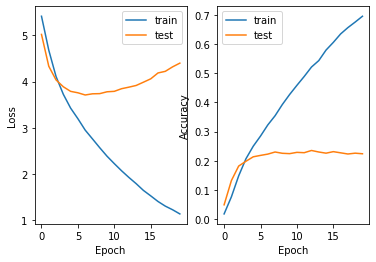

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(historynet_MobNetV2_V1.history['loss'])
plt.plot(historynet_MobNetV2_V1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(historynet_MobNetV2_V1.history['categorical_accuracy'])
plt.plot(historynet_MobNetV2_V1.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance sono molto alte sul training, intorno al 70%. Le performance sul validation rimangono intorno al 20%, come nel caso della prima versione della ResNet50. 

Si decide di non proseguire con nuove versioni per problemi di spazio e gpu. In ogni caso assumiamo che non si possano avere dei miglioramenti rispetto ai due modelli precedentemente citati, in cui le performance sul validation sono intorno al 20%. Tali modelli verranno utilizzati in fase di test sul validation degradato. 

In [ ]:
model1.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv1_MobNetV2.h5')

## 6) **Feature Extraction**



In quest'ultima parte abbiamo deciso di estrarre le features da due layer differenti della MobileNetV2. 

**Caso 1** <br>
Nel primo caso estraiamo le features dall'ultimo layer dense della MobileNetV2. Questa rete è stata addestrata per predire immagini appartenenti a 1280 classi diverse. Di conseguenza le features delle nostre immagini corrispondo ad un vettore composto da 1280 elementi. Tali features verranno classificate utilizzando una rete fully connected.

**Caso 2** <br>
Nel secondo caso estraiamo le features dal penultimo layer convoluzionale della MobileNetV2. Le features saranno immagini di dimensione 7x7x1280. Per la classificazione si utilizzerà la rete from scratch mymodel v6. 

### 6.1) **Import file con labels**

In [ ]:
train_labels = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/train_info_100fin.csv')
val_labels = pd.read_csv('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/val20.csv')

In [ ]:
train_labels

,Unnamed: 0,Name,Class
0,77200,train_059832.jpg,0
1,77177,train_059809.jpg,0
2,76809,train_059440.jpg,0
3,77216,train_059848.jpg,0
4,77191,train_059823.jpg,0
...,...,...,...
25029,57366,train_039689.jpg,162
25030,57367,train_039690.jpg,162
25031,57368,train_039691.jpg,162
25032,57369,train_039692.jpg,162


In [ ]:
train_labels = train_labels[['Name', 'Class']]
val_labels = val_labels[['Name', 'Class']]

In [ ]:
val_labels

,Name,Class
0,val_005999.jpg,0
1,val_003605.jpg,0
2,val_008780.jpg,0
3,val_000078.jpg,0
4,val_006173.jpg,0
...,...,...
4974,val_006665.jpg,189
4975,val_007712.jpg,189
4976,val_008322.jpg,189
4977,val_008666.jpg,189


In [ ]:
one_hot_encoded_train_labels = tf.keras.utils.to_categorical(train_labels['Class'])
len(one_hot_encoded_train_labels)

25034

In [ ]:
one_hot_encoded_val_labels = tf.keras.utils.to_categorical(val_labels['Class'])
len(one_hot_encoded_val_labels)

4979

In [ ]:
train_path = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Train/'
val_path = '/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Validation/'

### 6.2) **Output MobileNetV2 - vettore 1280 elementi**

#### 6.2.1) **Caricamento dati**

In [ ]:
trainfe_1280 = np.load('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Feature extraction/train_mobilenet.npy')

In [ ]:
type(trainfe_1280)

numpy.ndarray

In [ ]:
trainfe_1280.shape

(25034, 1280)

In [ ]:
valfe_1280 = np.load('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Feature extraction/val_mobilenet.npy')

In [ ]:
type(valfe_1280)

numpy.ndarray

In [ ]:
valfe_1280.shape

(4979, 1280)

#### 6.2.2) **Architecture v1**

In [ ]:
num_classes = 251

<IPython.core.display.Javascript object>

In [ ]:
inputs = keras.Input((1280,))

x = inputs

x = keras.layers.Dense(32,'relu')(x)
x = keras.layers.Dropout(0.15)(x)
x = keras.layers.Dense(16,'relu')(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)
net1_fe = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [ ]:
net1_fe.summary()

<IPython.core.display.Javascript object>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1280)]            0         
                                                                 
 dense_7 (Dense)             (None, 32)                40992     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 251)               4267      
                                                                 
Total params: 45,787
Trainable params: 45,787
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Network compilation

net1_fe.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =['categorical_accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# Training

history1_fe = net1_fe.fit(x = trainfe_1280,
                      y = one_hot_encoded_train_labels,
                      epochs = 50,
                      validation_data = (valfe_1280, one_hot_encoded_val_labels));

<IPython.core.display.Javascript object>

Epoch 1/50
783/783 [==============================] - 3s 4ms/step - loss: 5.4432 - categorical_accuracy: 0.0081 - val_loss: 5.1442 - val_categorical_accuracy: 0.0143
Epoch 2/50
783/783 [==============================] - 3s 4ms/step - loss: 5.1327 - categorical_accuracy: 0.0175 - val_loss: 4.8806 - val_categorical_accuracy: 0.0299
Epoch 3/50
783/783 [==============================] - 3s 4ms/step - loss: 4.9375 - categorical_accuracy: 0.0292 - val_loss: 4.7766 - val_categorical_accuracy: 0.0366
Epoch 4/50
783/783 [==============================] - 3s 4ms/step - loss: 4.8297 - categorical_accuracy: 0.0335 - val_loss: 4.5561 - val_categorical_accuracy: 0.0442
Epoch 5/50
783/783 [==============================] - 3s 3ms/step - loss: 4.7728 - categorical_accuracy: 0.0358 - val_loss: 4.5639 - val_categorical_accuracy: 0.0518
Epoch 6/50
783/783 [==============================] - 3s 4ms/step - loss: 4.7306 - categorical_accuracy: 0.0436 - val_loss: 4.5928 - val_categorical_accuracy: 0.0530
Epoc

<IPython.core.display.Javascript object>

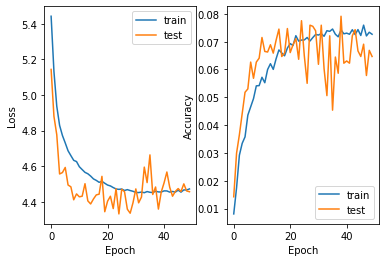

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(history1_fe.history['loss'])
plt.plot(history1_fe.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history1_fe.history['categorical_accuracy'])
plt.plot(history1_fe.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Performance notevolmente basse.

In [ ]:
net1_fe.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv1_fe1280.h5')

<IPython.core.display.Javascript object>

### 6.3) **Output (ultimo blocco convoluzionale) MobileNetV2 - immagini 7x7x1280**

#### 6.3.1) **Caricamento dati**

In [ ]:
trainfe_im = np.load('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Feature extraction/train_mobilenet_no_FC.npy')

In [ ]:
type(trainfe_im)

numpy.ndarray

In [ ]:
trainfe_im.shape

(25034, 1, 7, 7, 1280)

In [ ]:
trainfe_im2 = np.squeeze(trainfe_im)

In [ ]:
trainfe_im2.shape

(25034, 7, 7, 1280)

In [ ]:
valfe_im = np.load('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Data/Feature extraction/val_mobilenet_no_FC.npy')

In [ ]:
type(valfe_im)

numpy.ndarray

In [ ]:
valfe_im.shape

(4979, 1, 7, 7, 1280)

In [ ]:
valfe_im2 = np.squeeze(valfe_im)
valfe_im2.shape

(4979, 7, 7, 1280)

#### 6.3.2) **Architecture v1**

Architettura model v6 from scratch

In [ ]:
num_classes = 251

In [ ]:
# Architecture definition

inputs = keras.Input((7, 7, 1280))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net1_feim = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary

net1_feim.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 1280)]      0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          368672    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7, 7, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          18496 

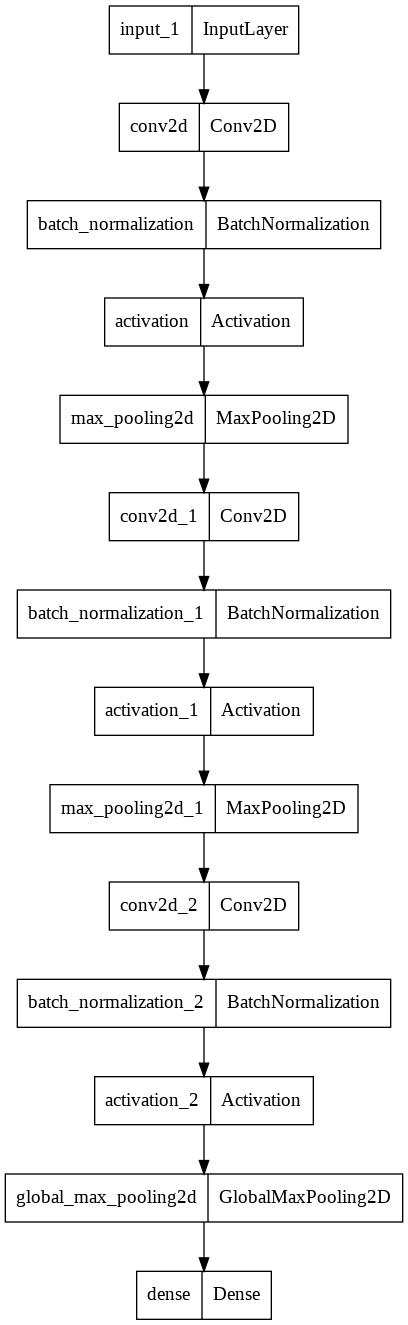

In [ ]:
# Architecture Plot

keras.utils.plot_model(net1_feim)

In [ ]:
# Network compilation

net1_feim.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
                  metrics =['categorical_accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [ ]:
# Training

history1_feim = net1_feim.fit(x = trainfe_im2,
                              y = one_hot_encoded_train_labels,
                              batch_size = 100,
                              epochs = 15,
                              validation_data = (valfe_im2, one_hot_encoded_val_labels),
                              callbacks=[callback]);

Epoch 1/15
251/251 [==============================] - 16s 24ms/step - loss: 5.2101 - categorical_accuracy: 0.0793 - val_loss: 4.5765 - val_categorical_accuracy: 0.1422
Epoch 2/15
251/251 [==============================] - 4s 18ms/step - loss: 4.3482 - categorical_accuracy: 0.2024 - val_loss: 4.3028 - val_categorical_accuracy: 0.1928
Epoch 3/15
251/251 [==============================] - 5s 18ms/step - loss: 4.0095 - categorical_accuracy: 0.2833 - val_loss: 4.3423 - val_categorical_accuracy: 0.2127
Epoch 4/15
251/251 [==============================] - 4s 18ms/step - loss: 3.7913 - categorical_accuracy: 0.3455 - val_loss: 4.3820 - val_categorical_accuracy: 0.2257
Epoch 5/15
251/251 [==============================] - 5s 18ms/step - loss: 3.6152 - categorical_accuracy: 0.4028 - val_loss: 4.6489 - val_categorical_accuracy: 0.2111
Epoch 6/15
251/251 [==============================] - 4s 18ms/step - loss: 3.4556 - categorical_accuracy: 0.4577 - val_loss: 4.8660 - val_categorical_accuracy: 0.20

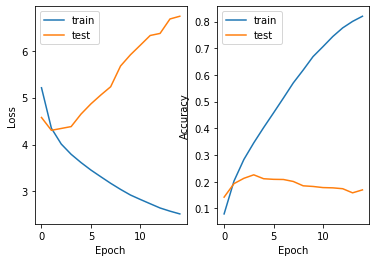

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(history1_feim.history['loss'])
plt.plot(history1_feim.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history1_feim.history['categorical_accuracy'])
plt.plot(history1_feim.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Le performance sono molto buone sul dataset di training, raggiungendo un valore di categorical accuracy pari al 82%. Siamo sempre in una situazione di forteoverfitting perchè le performance sul validation sono intorno al 20%. 
 

In [ ]:
# Saving
net1_feim.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv1_feim.h5')

#### 6.3.3 Architecture v2

Aggiunta del dropout.

In [ ]:
num_classes = 251

In [ ]:
# Architecture definition

inputs = keras.Input((7, 7, 1280))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.Dropout(0.15)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.Dropout(0.15)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.Dropout(0.15)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)


x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net2_feim = keras.Model(inputs, outputs)

In [ ]:
# Architecture summary

net2_feim.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 1280)]      0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7, 7, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                           

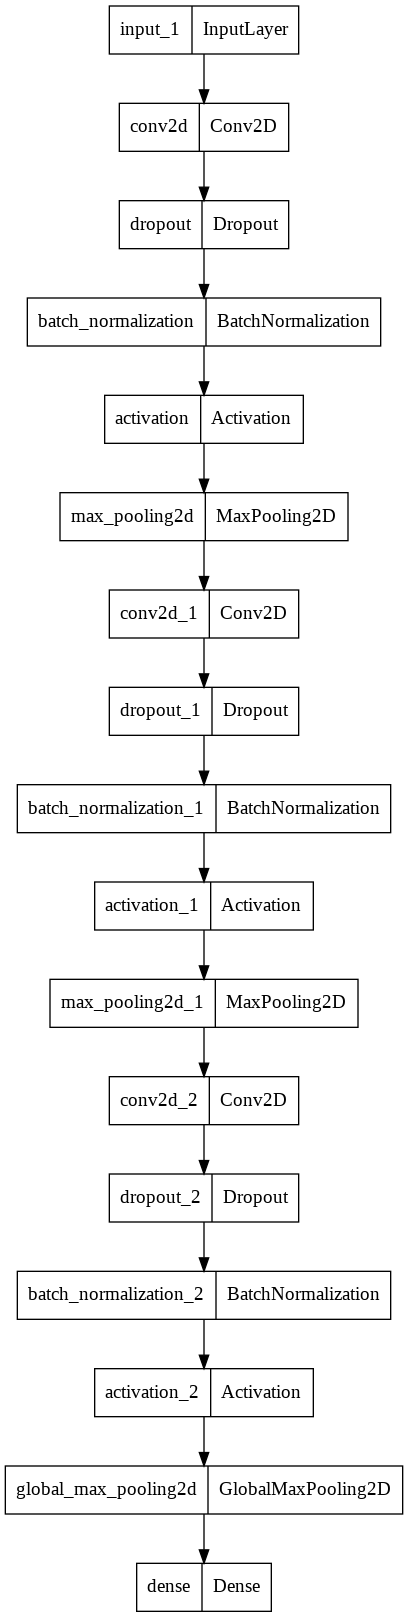

In [ ]:
# Architecture Plot

keras.utils.plot_model(net2_feim)

In [ ]:
# Network compilation

net2_feim.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
                  metrics =['categorical_accuracy'])

In [ ]:
# Training

history2_feim = net2_feim.fit(x = trainfe_im2,
                              y = one_hot_encoded_train_labels,
                              batch_size = 100,
                              epochs = 35,
                              validation_data = (valfe_im2, one_hot_encoded_val_labels));

Epoch 1/35
251/251 [==============================] - 15s 25ms/step - loss: 5.3673 - categorical_accuracy: 0.0570 - val_loss: 4.7855 - val_categorical_accuracy: 0.1151
Epoch 2/35
251/251 [==============================] - 5s 18ms/step - loss: 4.5799 - categorical_accuracy: 0.1526 - val_loss: 4.6019 - val_categorical_accuracy: 0.1707
Epoch 3/35
251/251 [==============================] - 5s 18ms/step - loss: 4.3189 - categorical_accuracy: 0.2170 - val_loss: 4.4983 - val_categorical_accuracy: 0.2169
Epoch 4/35
251/251 [==============================] - 5s 18ms/step - loss: 4.1905 - categorical_accuracy: 0.2595 - val_loss: 4.6847 - val_categorical_accuracy: 0.1896
Epoch 5/35
251/251 [==============================] - 5s 18ms/step - loss: 4.1259 - categorical_accuracy: 0.2971 - val_loss: 4.6805 - val_categorical_accuracy: 0.2209
Epoch 6/35
251/251 [==============================] - 5s 18ms/step - loss: 4.0770 - categorical_accuracy: 0.3269 - val_loss: 4.6457 - val_categorical_accuracy: 0.22

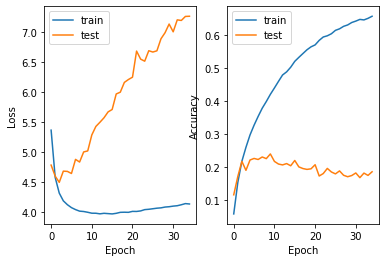

In [ ]:
# Learning curves visualization

plt.subplot(1, 2, 1)
plt.plot(history2_feim.history['loss'])
plt.plot(history2_feim.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history2_feim.history['categorical_accuracy'])
plt.plot(history2_feim.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

Performance simili al modello precedente ma leggermente più basse. 

In [ ]:
# Saving
net2_feim.save('/content/gdrive/MyDrive/Visual Processing and Image Management/Progetto FoodX-251/Models/mymodelv2_feim.h5')